<a href="https://colab.research.google.com/github/elliotgunn/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

X variable:
predictor, explanatory, feature, independent

Y variable:
predicted, explained, target, dependent

In [93]:
import random
dir(random)  # Reminding ourselves what we can do here


['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [94]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
#namedtuple: fancy data structure, useful because we can generate each user individually, and then its easy to put the list into a dataframe

# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [95]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  #^ 0.1 is the initial likelihood of purchasing which is smaller. so the + is the increased likelihood of purchasing predicated on the prior randomly generated time_on_site.
  # we need the purchased value to be a bool. 
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])
#the first ten users

[User(purchased=True, time_on_site=372.3830619579334, mobile=False), User(purchased=True, time_on_site=333.0360577005804, mobile=False), User(purchased=True, time_on_site=263.33786270827284, mobile=True), User(purchased=False, time_on_site=179.943844304955, mobile=True), User(purchased=False, time_on_site=267.6799853561355, mobile=True), User(purchased=False, time_on_site=160.85238803144068, mobile=True), User(purchased=False, time_on_site=310.65813838141804, mobile=False), User(purchased=False, time_on_site=78.8279060165546, mobile=True), User(purchased=False, time_on_site=394.33294654286857, mobile=False), User(purchased=False, time_on_site=53.89589122460648, mobile=True)]


In [96]:
#there's an issue with pandas version, so we need to change version of pandas library

!pip freeze
#tool for installing new versions of libraries
#pandas==0.24.2, we need a downgraded version

absl-py==0.7.1
alabaster==0.7.12
albumentations==0.1.12
altair==3.1.0
astor==0.8.0
astropy==3.0.5
atari-py==0.1.15
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.8
autograd==1.2
Babel==2.7.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
blis==0.2.4
bokeh==1.0.4
boto==2.49.0
boto3==1.9.180
botocore==1.12.180
Bottleneck==1.2.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.1
certifi==2019.6.16
cffi==1.12.3
chainer==5.4.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.14.6
cvxopt==1.2.3
cvxpy==1.0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.10
daft==0.0.4
dask==1.1.5
dataclasses==0.6
datascience==0.10.6
decorator==4.4.0
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.0
distributed==1.25.3
Django==2.2.2
dlib==19.16.0
dm-sonnet==1.33
docopt==0.6.2
docutils==0.14
dopamine-rl==1.0.5
easy

In [97]:
pip install pandas==0.23.4

In [98]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()
#using NAMEDTUPLES gives us headers. otherwise just TUPLES doesn't give it.

#time_on_site is continuous

,purchased,time_on_site,mobile
0,True,372.383062,False
1,True,333.036058,False
2,True,263.337863,True
3,False,179.943844,True
4,False,267.679985,True


In [99]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

#because time_on_site is a continuous variable, this is not very useful
#crosstabs are typically used to compare categorical variables

time_on_site,6.172966844967938,6.924253618818034,7.134980286341245,7.5733985661232825,8.055190463892163,8.453600057533134,8.480011790959246,8.648554181516928,8.959262359230278,9.005768947051077,9.505467349382819,9.902297098583695,10.025034303259108,10.342086167085018,11.274377855920928,12.024135322949617,12.03098260370485,12.248438975396098,12.389351589548475,12.587579731054195,13.13792911538424,13.235821921014328,13.363841165168164,13.594822222731507,13.873321723163988,14.112467548053418,15.380787910434776,15.545299539817572,15.731583720413813,15.935937056953238,15.957140987181091,15.958407277645078,16.040153706962116,16.31748494959584,17.080818914725196,17.80694230714839,18.277201931982074,19.775034798592777,19.997027758510143,20.17101462037489,...,490.98252199550865,494.1780156140406,494.89660577878266,495.8690404699022,496.19499829925564,498.5557463795418,499.7154241460697,507.2288231543147,508.69067919591566,515.8113871771166,519.3115393297002,521.2482485751025,522.673898992681,526.4939461749826,527.2965785388753,528.5348044147125,529.8507414950122,540.1306422083615,540.7163102106535,550.6161292912788,551.8723941336418,557.5304403313163,558.5858301473039,568.0917325420689,568.7206390472043,573.4619978858267,576.1494447187935,576.570124036797,576.6102215747476,576.8706968862876,576.8901695151474,578.3717057404406,580.8615832831002,585.4059389543943,589.7552428660753,591.8385202803826,594.7131386341403,594.9075456752574,595.4019681747066,595.7623885261132
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,0,1,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,1,0,0,1,...,1,1,0,0,0,1,1,0,1,1,0,1,0,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,0,1,0,0,1,1,1,0,1,1,0,1
True,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,1,0,...,0,0,1,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0


In [100]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them


time_bins = pd.cut(user_data['time_on_site'], 6)  # 6 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)


#note interval notation: ( means exclusive, [ is inclusive

time_on_site,"(5.583, 104.438]","(104.438, 202.703]","(202.703, 300.968]","(300.968, 399.233]","(399.233, 497.497]","(497.497, 595.762]"
purchased,,,,,,
False,218,174,167,39,24,24
True,79,114,119,11,20,11


In [101]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')
#this takes raw values in table into percentages of users buying within time period, which is better for analyzing than just looking at the raw count which leads to 
#strange interpretations (more time spent on site, less purchasing)

time_on_site,"(5.583, 104.438]","(104.438, 202.703]","(202.703, 300.968]","(300.968, 399.233]","(399.233, 497.497]","(497.497, 595.762]"
purchased,,,,,,
False,0.734007,0.604167,0.583916,0.78,0.545455,0.685714
True,0.265993,0.395833,0.416084,0.22,0.454545,0.314286


In [102]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.768,0.605333
True,0.232,0.394667


In [103]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?


pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], normalize='index')
#changed the bins from 5 to 6 as otherwise the middle section is overweighted and biased towards desktop users
#each row = 100% bc we normalized by index which is 'purchased'


purchased               False        ...                      True 
time_on_site (5.583, 104.438]        ...         (497.497, 595.762]
mobile                               ...                           
False                   0.188        ...                      0.044
True                    0.228        ...                      0.000

[2 rows x 12 columns]

In [104]:
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], normalize='index')

type(ct)

pandas.core.frame.DataFrame

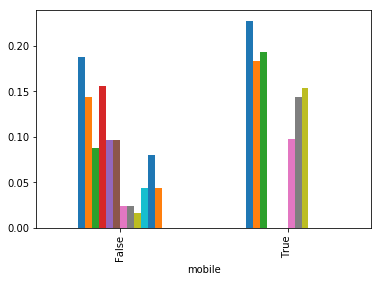

In [105]:
ct.plot(kind='bar', legend=False);


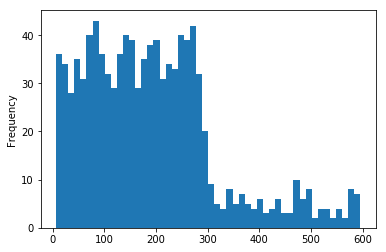

In [106]:
user_data['time_on_site'].plot.hist(bins=50);

In [107]:
user_data[user_data['mobile']==False]
#only giving desktop users

,purchased,time_on_site,mobile
0,True,372.383062,False
1,True,333.036058,False
6,False,310.658138,False
8,False,394.332947,False
12,False,242.694698,False
17,False,576.570124,False
21,False,218.136071,False
22,False,131.374201,False
29,False,31.086949,False
31,True,50.899793,False


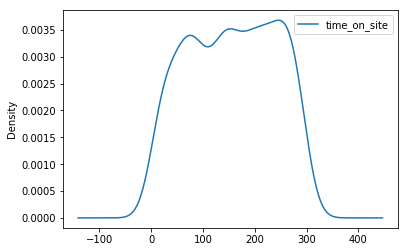

In [108]:
user_data[user_data['mobile']==True].plot.density();

In [0]:
#user_data[(user_data['mobile'])]

#plot.hist(bins=50);

In [110]:
#new tool, pivot table!

pt = pd.pivot_table(user_data, values='purchased', index=time_bins)
pt

#this should be very similar to the crosstab earlier

,purchased
time_on_site,
"(5.583, 104.438]",0.265993
"(104.438, 202.703]",0.395833
"(202.703, 300.968]",0.416084
"(300.968, 399.233]",0.220000
"(399.233, 497.497]",0.454545
"(497.497, 595.762]",0.314286


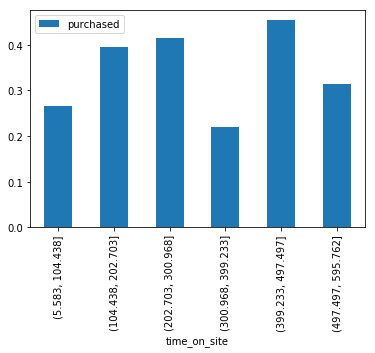

In [111]:
pt.plot.bar()

In [112]:
ct = pd.crosstab(time_bins, [user_data['purchased'],user_data['mobile']], normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(5.583, 104.438]    0.244792  0.376652  0.103448  0.246622
(104.438, 202.703]  0.187500  0.303965  0.103448  0.364865
(202.703, 300.968]  0.114583  0.319383  0.068966  0.388514
(300.968, 399.233]  0.203125  0.000000  0.189655  0.000000
(399.233, 497.497]  0.125000  0.000000  0.344828  0.000000
(497.497, 595.762]  0.125000  0.000000  0.189655  0.000000

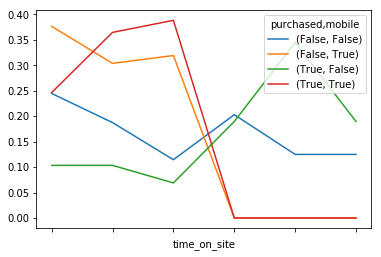

In [113]:
ct.plot();

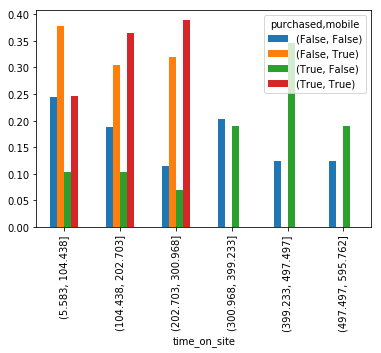

In [114]:
ct.plot(kind='bar');

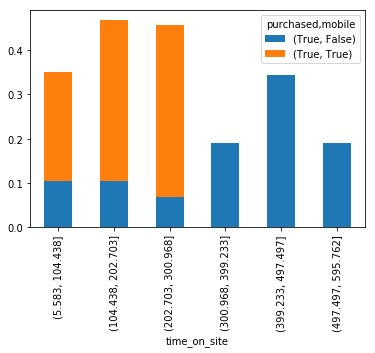

In [115]:
ct_sliced = ct.iloc[:, [2,3]]
ct_sliced.plot(kind='bar', stacked=True)

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself


#find the CT that tells the story and generates a plot to show your analysis

## Preliminary data cleaning

In [117]:
#load data

file_url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv'

import pandas as pd

exercise_data = pd.read_csv(file_url, index_col=0)

#?pd.read_csv

!pip install pandas==0.23.4

exercise_data.head()


,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [118]:
exercise_data.isna().sum()

age              0
weight           0
exercise_time    0
dtype: int64

In [119]:
exercise_data.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

## High level associations

In [120]:
#correlation matrix shows the expected directions of effect, nothing anomalous
exercise_data.corr()

,age,weight,exercise_time
age,1.000000,0.144168,-0.273818
weight,0.144168,1.000000,-0.478021
exercise_time,-0.273818,-0.478021,1.000000


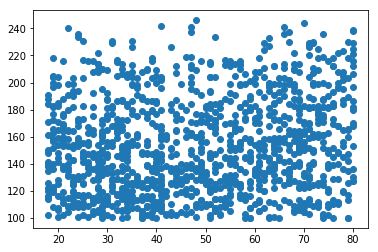

In [121]:
import matplotlib.pyplot as plt

plt.scatter(exercise_data['age'], exercise_data['weight']);

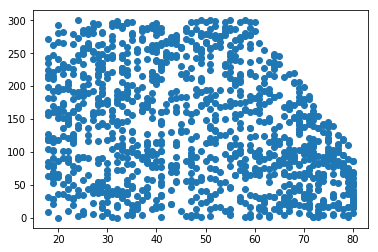

In [122]:
plt.scatter(exercise_data['age'], exercise_data['exercise_time']);

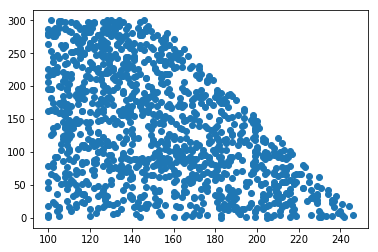

In [123]:
plt.scatter(exercise_data['weight'], exercise_data['exercise_time']);

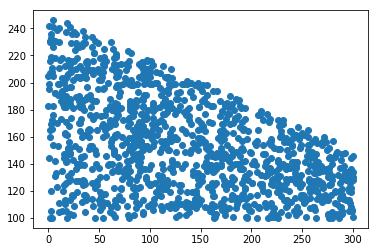

In [124]:
plt.scatter(exercise_data['exercise_time'], exercise_data['weight']);

In [125]:
#crosstabulation to see what's going on
time_bins = pd.cut(exercise_data['exercise_time'],4)
weight_bins = pd.cut(exercise_data['weight'],4)
pd.crosstab(weight_bins, time_bins, normalize='columns')
#normalizing by columns means that each row = 100%

exercise_time,"(-0.3, 75.0]","(75.0, 150.0]","(150.0, 225.0]","(225.0, 300.0]"
weight,,,,
"(99.854, 136.5]",0.230986,0.290698,0.459770,0.633333
"(136.5, 173.0]",0.250704,0.337209,0.398467,0.366667
"(173.0, 209.5]",0.301408,0.316860,0.141762,0.000000
"(209.5, 246.0]",0.216901,0.055233,0.000000,0.000000


In [126]:
pt = pd.pivot_table(exercise_data, values='exercise_time', index=weight_bins)
pt

,exercise_time
weight,
"(99.854, 136.5]",171.931718
"(136.5, 173.0]",144.206549
"(173.0, 209.5]",88.296443
"(209.5, 246.0]",44.239583


In [127]:
pt = pd.pivot_table(exercise_data, values='weight', index=time_bins)
pt

,weight
exercise_time,
"(-0.3, 75.0]",172.723944
"(75.0, 150.0]",159.287791
"(150.0, 225.0]",141.095785
"(225.0, 300.0]",130.462500


## Transform 'age' variable

I split age into two large groups because generally we know that younger individuals generally weigh less and exercise more. We know this from the correlation matrix. This cross tab confirms that, within comparable age groups, individuals who weigh less are associated with higher exercise times. We still don't know the direction of effect. 

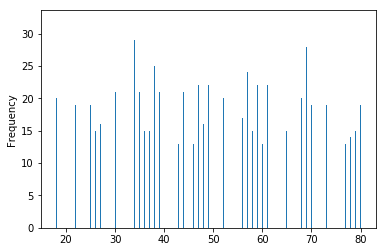

In [128]:
exercise_data['age'].plot.hist(600);
#age data is very uniform

#I want to transform age data into something categorical: young, middle, old.  

exercise_data.quantile(.5)
#0.5 quartile = 48 years
import numpy as np
exercise_data['age_cohort'] = np.where(exercise_data['age']>=48.0,'Old','Young')


In [129]:
exercise_data.head()

,age,weight,exercise_time,age_cohort
0,44,118,192,Young
1,41,161,35,Young
2,46,128,220,Young
3,39,216,57,Young
4,28,116,182,Young


## Potential confounding by age

In [130]:
age_bins = pd.cut(exercise_data['age'], 2)

pd.crosstab(age_bins, weight_bins, normalize='columns')

weight,"(99.854, 136.5]","(136.5, 173.0]","(173.0, 209.5]","(209.5, 246.0]"
age,,,,
"(17.938, 49.0]",0.572687,0.544081,0.442688,0.395833
"(49.0, 80.0]",0.427313,0.455919,0.557312,0.604167


In [131]:
pd.crosstab(age_bins, time_bins, normalize='columns')

exercise_time,"(-0.3, 75.0]","(75.0, 150.0]","(150.0, 225.0]","(225.0, 300.0]"
age,,,,
"(17.938, 49.0]",0.416901,0.436047,0.613027,0.7
"(49.0, 80.0]",0.583099,0.563953,0.386973,0.3


Let's look at all three at once, but using 'age_cohort'. Again, the direction of effect isn't clear so we'll run it both ways.

In [132]:
ct = pd.crosstab(exercise_data['age_cohort'], [weight_bins, time_bins], normalize="index")
ct

weight        (99.854, 136.5]      ...       (209.5, 246.0]
exercise_time    (-0.3, 75.0]      ...        (75.0, 150.0]
age_cohort                         ...                     
Old                  0.088235      ...             0.022876
Young                0.047619      ...             0.008503

[2 rows x 13 columns]

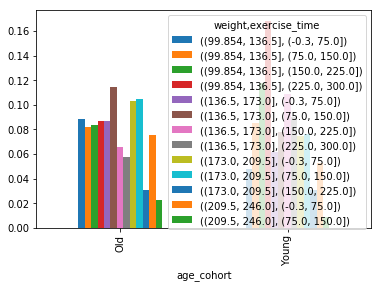

In [133]:
ct.plot(kind='bar');

I think we can finally get some idea of what is happening here. The two bar plots show that the relationship between weight and exercise is slightly different between the age cohorots. 

In the first bar plot 

In [134]:
ct = pd.crosstab(exercise_data['age_cohort'], [time_bins, weight_bins], normalize="index")
ct

exercise_time    (-0.3, 75.0]      ...       (225.0, 300.0]
weight        (99.854, 136.5]      ...       (136.5, 173.0]
age_cohort                         ...                     
Old                  0.088235      ...             0.057190
Young                0.047619      ...             0.090136

[2 rows x 13 columns]

In [135]:
ct = pd.crosstab(time_bins, [exercise_data['age_cohort'],weight_bins], normalize="index")
ct

age_cohort                 Old      ...                Young
weight         (99.854, 136.5]      ...       (209.5, 246.0]
exercise_time                       ...                     
(-0.3, 75.0]          0.152113      ...             0.087324
(75.0, 150.0]         0.145349      ...             0.014535
(150.0, 225.0]        0.195402      ...             0.000000
(225.0, 300.0]        0.220833      ...             0.000000

[4 rows x 8 columns]

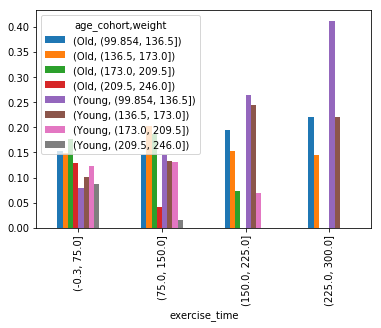

In [136]:
ct.plot(kind='bar');

## Age cohort analysis

I want to make two crosstab tables that only differ by age cohort.

In [146]:
exercise_data_old = exercise_data[exercise_data['age_cohort']=='Old']
time_bins = pd.cut(exercise_data_old['exercise_time'],4)
weight_bins = pd.cut(exercise_data_old['weight'],4)

ct_old = pd.crosstab(weight_bins, time_bins, normalize='index')
ct_old


exercise_time,"(0.701, 75.75]","(75.75, 150.5]","(150.5, 225.25]","(225.25, 300.0]"
weight,,,,
"(99.854, 136.5]",0.259615,0.240385,0.245192,0.254808
"(136.5, 173.0]",0.267677,0.353535,0.202020,0.176768
"(173.0, 209.5]",0.431507,0.438356,0.130137,0.000000
"(209.5, 246.0]",0.766667,0.233333,0.000000,0.000000


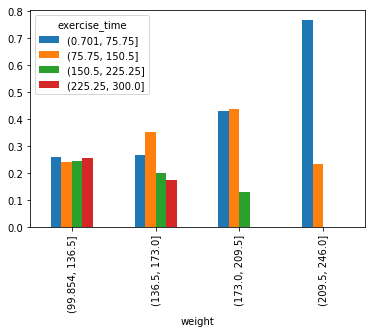

In [147]:
ct_old.plot(kind='bar');

In [148]:
exercise_data_young = exercise_data[exercise_data['age_cohort']=='Young']
time_bins = pd.cut(exercise_data_young['exercise_time'],4)
weight_bins = pd.cut(exercise_data_young['weight'],4)

ct_young = pd.crosstab(weight_bins, time_bins, normalize='index')
ct_young



exercise_time,"(-0.3, 75.0]","(75.0, 150.0]","(150.0, 225.0]","(225.0, 300.0]"
weight,,,,
"(99.858, 135.5]",0.112033,0.207469,0.273859,0.406639
"(135.5, 171.0]",0.180412,0.226804,0.319588,0.273196
"(171.0, 206.5]",0.376147,0.403670,0.211009,0.009174
"(206.5, 242.0]",0.818182,0.181818,0.000000,0.000000


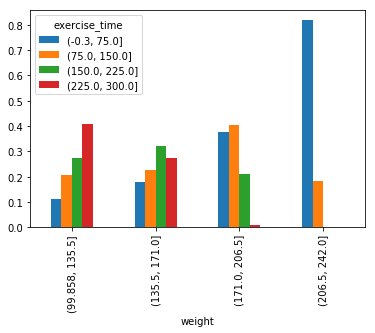

In [149]:
ct_young.plot(kind='bar');

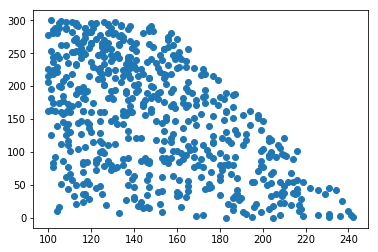

In [139]:
plt.scatter(exercise_data_young['weight'], exercise_data_young['exercise_time']);

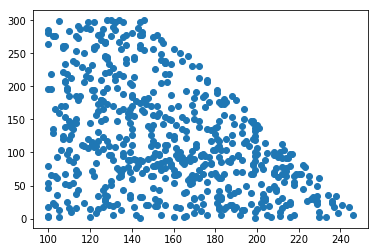

In [140]:
plt.scatter(exercise_data_old['weight'], exercise_data_old['exercise_time']);

## Stratification
Objective of stratification is to fix the level of the confounders and produce groups within which the confounder does not vary. Then evaluate the exposure-outcome association within each stratum of the confounder. So within each stratum, the confounder cannot confound because it does not vary across the exposure-outcome.

In [0]:
#this builds on the previous section, since I have already created two age cohort dataframes

In [153]:
from sklearn.linear_model import LinearRegression

features = ['age', 'exercise_time']

target = 'weight'

model = LinearRegression()
model.fit(exercise_data[features], exercise_data[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

They are integers.

2.  What are the relationships between the variables?

I did a correlation matrix to quickly verify the direction of association between variables. As expected,  age is positively correlated with weight and negatively corr with exercise time. Weight is negatively corr with exercise time. 

I think a typical researcher would be interested in the relationship between weight and exercise time. What we're not sure about is the direction of this effect, and to what extent age is a confounding variable. For instance, heavier individuals may spend less time exercising because it is less enjoyable. Or, individuals are heavier precisely because they spend less time exercising. 

Hence, we will treat the main relationship of interest to be the one between weight and exercise. Age is the potential confounder. 

What might be illuminating, is look at the relationship between weight and exercise time via *age groups*. 

I tried to an age cohort analysis as suggested in the stretch goal (the NIH highlights piece). 

3.  Which relationships are "real", and which spurious?

At this stage in the analysis, I don't think it's possible to definitively show that any relationships are spurious. It's more likely that age is a confounder. We can see in the exploratory visuals that age affects both weight and exercise time in opposite ways. 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)